In [1]:
from Game import *

Version:  0.2.30


## Game functions

In [2]:
def initial_state():
    state=Board(3,3)
    state.pieces=[".","X","O"]
    return state

def show_state(state):
    print(state)
    
def valid_moves(state,player):
    # run through all the spots
    # if it is empty, then append that
    # location to the possible moves
    
    moves=[]
    for location in range(9):
        if state[location]==0:
            moves.append(location)
            
    return moves  

def update_state(state,player,move):
    new_state=state
    
    new_state[move]=player
    return new_state    
    
def win_status(state,player):
    # the state is *after* the move for the player

    #  0  1  2 
    #  3  4  5 
    #  6  7  8   
    
    for start,middle,end in [
        [0,1,2],[3,4,5],[6,7,8],
        [0,3,6],[1,4,7],[2,5,8],
        [0,4,8],[2,4,6],
                ]:
        
        if state[start]==player and state[middle]==player and state[end]==player:
            return "win"
        
    if player==1:
        other_player=2
    else:
        other_player=1
    
    if not valid_moves(state,other_player):
        return "stalemate"
    

## Agent Functions

In [3]:
def human_move(state,player):
    
    state.show_locations()
    print("Player",player)
    move=int(input("which square to move?"))
    return move

human_agent=Agent(human_move)     

In [4]:
def random_move(state,player):
    
    move=random.choice(valid_moves(state,player))
    return move


random_agent=Agent(random_move)

In [5]:
from Game.minimax import *
def minimax_move(state,player):

    values,moves=minimax_values(state,player,display=True)
    return top_choice(moves,values)


minimax_agent=Agent(minimax_move)

## Skittles Agent

In [6]:
def skittles_move(state,player,info):
    T=info.T
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    if state not in T:
        actions=valid_moves(state,player)
        T[state]=Table()
        for action in actions:
            T[state][action]=2  # initial number of skittles
    
    move=weighted_choice(T[state])
    
    if move is None:  
        
        # learn
        if learning:
            if last_state:
                T[last_state][last_action]-=1 # take away a skittle
                if T[last_state][last_action]<0:
                    T[last_state][last_action]=0
    
        return random_move(state,player)
    else:
        return move

In [7]:
def skittles_after(status,player,info):
    # not return anything but...
    # will adjust the skittles table if lost the game
    T=info.T
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    if learning:
        if status=='lose':  # only learn when you lose
            T[last_state][last_action]-=1 # take away a skittle
            if T[last_state][last_action]<0:
                T[last_state][last_action]=0

In [8]:
skittles1_agent=Agent(skittles_move)
skittles1_agent.post=skittles_after
skittles1_agent.T=Table()  # makes an empty table
skittles1_agent.learning=True

skittles2_agent=Agent(skittles_move)
skittles2_agent.post=skittles_after
skittles2_agent.T=Table()  # makes an empty table
skittles2_agent.learning=True

## Running the Game

In [9]:
g=Game()
g.run(skittles1_agent,skittles2_agent)

====
Game  1
 .  .  . 
 .  .  . 
 .  .  . 

Player 1 moves 6
 .  .  . 
 .  .  . 
 X  .  . 

Player 2 moves 1
 .  O  . 
 .  .  . 
 X  .  . 

Player 1 moves 3
 .  O  . 
 X  .  . 
 X  .  . 

Player 2 moves 0
 O  O  . 
 X  .  . 
 X  .  . 

Player 1 moves 4
 O  O  . 
 X  X  . 
 X  .  . 

Player 2 moves 7
 O  O  . 
 X  X  . 
 X  O  . 

Player 1 moves 5
 O  O  . 
 X  X  X 
 X  O  . 

Player  1 won.


[1]

In [10]:
%%time 
N_train=500
N_test=100
iteration_count=0

skittles1_agent.T=Table()  # makes an empty table
skittles2_agent.T=Table()  # makes an empty table

percentage_won_player1=[]
percentage_won_player2=[]
percentage_tie=[]
number_of_iterations=[]

for i in range(200):

    skittles1_agent.learning=True
    skittles2_agent.learning=True
    g=Game(number_of_games=N_train)
    g.display=False
    result=g.run(skittles1_agent,skittles2_agent)


    # turn learning off to test
    skittles1_agent.learning=False
    skittles2_agent.learning=False
    g=Game(number_of_games=N_test)
    g.display=False
    result=g.run(skittles1_agent,skittles2_agent)
    iteration_count+=N_train

    percentage_won_player1.append(result.count(1)/N_test*100)
    percentage_won_player2.append(result.count(2)/N_test*100)
    percentage_tie.append(result.count(0)/N_test*100)
    number_of_iterations.append(iteration_count)

    
SaveTable(skittles1_agent.T,"TTT skittles1 table.json")     
SaveTable(skittles2_agent.T,"TTT skittles2 table.json")     

CPU times: user 3min 53s, sys: 991 ms, total: 3min 54s
Wall time: 8min 28s


In [11]:
%matplotlib inline
from pylab import plot,xlabel,ylabel,legend,figure

Text(0, 0.5, 'Percentage Won')

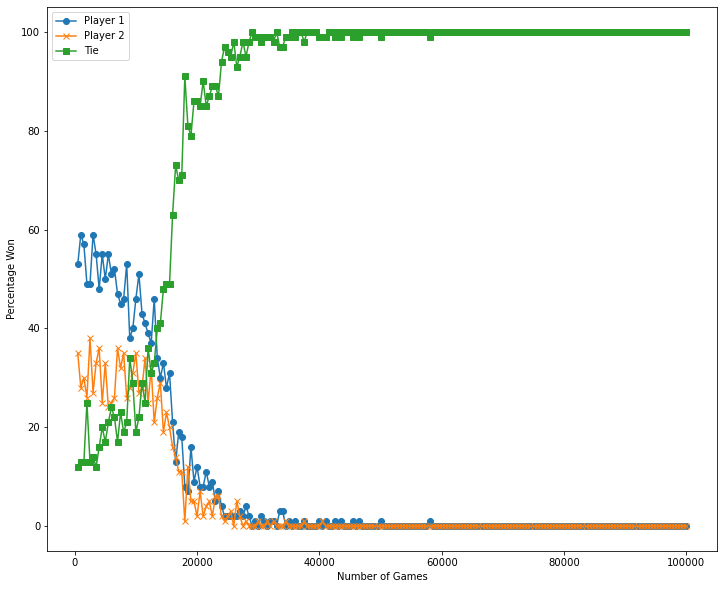

In [12]:
figure(figsize=(12,10))
plot(number_of_iterations,percentage_won_player1,'-o',label='Player 1')
plot(number_of_iterations,percentage_won_player2,'-x',label='Player 2')
plot(number_of_iterations,percentage_tie,'-s',label='Tie')
legend()
xlabel('Number of Games')
ylabel('Percentage Won')

## Loading a game

In [13]:
skittles1_agent=Agent(skittles_move)
skittles1_agent.post=skittles_after
skittles1_agent.T=LoadTable("TTT skittles1 table.json")  # makes an empty table
skittles1_agent.learning=True

skittles2_agent=Agent(skittles_move)
skittles2_agent.post=skittles_after
skittles2_agent.T=LoadTable("TTT skittles2 table.json")  # makes an empty table
skittles2_agent.learning=True

In [14]:
g=Game()
g.run(skittles1_agent,skittles2_agent)

====
Game  1
 .  .  . 
 .  .  . 
 .  .  . 

Player 1 moves 6
 .  .  . 
 .  .  . 
 X  .  . 

Player 2 moves 4
 .  .  . 
 .  O  . 
 X  .  . 

Player 1 moves 8
 .  .  . 
 .  O  . 
 X  .  X 

Player 2 moves 7
 .  .  . 
 .  O  . 
 X  O  X 

Player 1 moves 1
 .  X  . 
 .  O  . 
 X  O  X 

Player 2 moves 5
 .  X  . 
 .  O  O 
 X  O  X 

Player 1 moves 3
 .  X  . 
 X  O  O 
 X  O  X 

Player 2 moves 0
 O  X  . 
 X  O  O 
 X  O  X 

Player 1 moves 2
 O  X  X 
 X  O  O 
 X  O  X 

Neither player won:  stalemate


[0]